In [1]:
from google.colab import drive
 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install transformers torchvision

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
import re 
import numpy as np 
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models
from sklearn.metrics import classification_report
from collections import Counter
from collections import defaultdict
from gensim.models import KeyedVectors
from torchvision import transforms
import torchvision
from PIL import Image

In [5]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0


df_train = pd.read_csv("./gdrive/MyDrive/Models/train_processed.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)



df_val = pd.read_csv("./gdrive/MyDrive/Models/val_processed.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test_processed.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)

In [6]:
weights = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/crisisNLP_word2vec_model/crisisNLP_word_vector.bin', binary=True)
weights = torch.FloatTensor(weights.vectors)

In [7]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths):
    self.tweets = tweets
    self.targets = targets  
    self.paths = paths
    self.transform = transforms.Compose([
      transforms.Resize(size=256),
      transforms.CenterCrop(size=224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = self.tweets[item]
    target = self.targets[item]

    tweet = tweet.split()
    tweet = list(map(int, tweet))

    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img) 

    return {
      'input_ids': torch.tensor(tweet),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy()
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    drop_last=True
  )

In [8]:
class TweetClassifier(nn.Module):

    def __init__(self, weights, vocab_size, embedding_dim):

        super(TweetClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.embedding.requires_grad = False

        self.vgg = torchvision.models.vgg16(pretrained=True)
        self.image_dense = nn.Linear(1000, 1000)
        self.image_bn = nn.BatchNorm1d(1000)
        for param in self.vgg.parameters():
          param.requires_grad = False
        
        
        self.y = nn.Conv2d(1,300, (4, embedding_dim))
        self.y_relu = nn.ReLU()
        self.y_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 4 + 1, 1))


        self.z = nn.Conv2d(1,300, (3, embedding_dim))
        self.z_relu = nn.ReLU()
        self.z_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 3 + 1, 1))

        self.z1 = nn.Conv2d(1,300, (2, embedding_dim))
        self.z1_relu = nn.ReLU()
        self.z1_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 2 + 1, 1))

        self.w1 = nn.Conv2d(1,300, (1, embedding_dim))
        self.w1_relu = nn.ReLU()
        self.w1_pool = nn.MaxPool2d((MAX_SEQUENCE_LENGTH - 1 + 1, 1))

        self.text_dense = nn.Linear(1200, 1000)
        self.text_bn = nn.BatchNorm1d(1000)

        self.bn = nn.BatchNorm1d(2000)
        self.linear1 = nn.Linear(2000, 1000)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.4)

        self.linear2 = nn.Linear(1000, 500)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)

        self.linear3 = nn.Linear(500, 100)
        self.relu3    = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.02)

        self.linear4 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()


        


    def forward(self, input_ids, tweet_img):

        # embedded vectors
        embeds = self.embedding(input_ids) # (batch_size, seq_length, embedding_dim)
        # embeds.unsqueeze(1) creates a channel dimension that conv layers expect
        embeds = embeds.unsqueeze(1)

        y_out = self.y(embeds)
        y_out = self.y_relu(y_out)
        y_out = self.y_pool(y_out)

        z_out = self.z(embeds)
        z_out = self.z_relu(z_out)
        z_out = self.z_pool(z_out)

        z1_out = self.z1(embeds)
        z1_out = self.z1_relu(z1_out)
        z1_out = self.z1_pool(z1_out)

        w1_out = self.w1(embeds)
        w1_out = self.w1_relu(w1_out)
        w1_out = self.w1_pool(w1_out)

        text_output = torch.cat((y_out, z_out, z1_out, w1_out), dim=1)
        text_output = torch.squeeze(text_output,3)
        text_output = torch.squeeze(text_output,2)
        
        text_output = self.text_dense(text_output)
        text_output = self.text_bn(text_output)

        image_output = self.vgg(tweet_img)
        image_output = self.image_dense(image_output)
        image_output = self.image_bn(image_output)

        merged_output = torch.cat((text_output, image_output), dim=1)

        merged_output = self.bn(merged_output)
        merged_output = self.linear1(merged_output)
        merged_output = self.relu1(merged_output)
        merged_output = self.dropout1(merged_output)

        merged_output = self.linear2(merged_output)
        merged_output = self.relu2(merged_output)
        merged_output = self.dropout2(merged_output)

        merged_output = self.linear3(merged_output)
        merged_output = self.relu3(merged_output)
        merged_output = self.dropout3(merged_output)

        merged_output = self.linear4(merged_output)

        probas = self.sigmoid(merged_output)
        return probas


In [9]:
vocab_size = 2152854 #len(pretrained_words)
embedding_dim = 300 #len(embed_lookup[pretrained_words[0]])
MAX_SEQUENCE_LENGTH = 25

batch_size = 128
EPOCHS = 100

train_data_loader = create_data_loader(df_train, batch_size)
val_data_loader = create_data_loader(df_val, batch_size)
test_data_loader = create_data_loader(df_test, batch_size)

model = TweetClassifier(weights, vocab_size, embedding_dim)
model = model.to(device)

lr=0.00001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, min_lr=0, verbose=False)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [10]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
        input_ids = input_ids, 
        tweet_img = tweet_imgs
        )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids = input_ids, 
        tweet_img = tweet_imgs
        )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6375099889437358 accuracy 0.7335694198520987
Val   loss 0.5702500442663828 accuracy 0.7533375715193897

Epoch 2/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5090065924326579 accuracy 0.7921049890636391
Val   loss 0.4593449831008911 accuracy 0.782581055308328

Epoch 3/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4186499547958374 accuracy 0.8174148526195187
Val   loss 0.4046705091993014 accuracy 0.7952956134774317

Epoch 4/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3702521409591039 accuracy 0.8440787417977293
Val   loss 0.37777769813934964 accuracy 0.8130959949141767

Epoch 5/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3427971951166789 accuracy 0.8537652327882512
Val   loss 0.3660999710361163 accuracy 0.8207247298156389

Epoch 6/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3252270495891571 accuracy 0.8623060097906468
Val   loss 0.3584919298688571 accuracy 0.8226319135410045

Epoch 7/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3059338984886805 accuracy 0.868867826268097
Val   loss 0.3561056926846504 accuracy 0.8258105530832803

Epoch 8/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2910545603434245 accuracy 0.8744922403916259
Val   loss 0.3549407223860423 accuracy 0.8321678321678322

Epoch 9/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2714917137225469 accuracy 0.8850119779189668
Val   loss 0.36205459882815677 accuracy 0.8302606484424666

Epoch 10/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2504341514905294 accuracy 0.8959483387147172
Val   loss 0.3677958957850933 accuracy 0.8321678321678322

Epoch 11/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23283490796883902 accuracy 0.9039683366316008
Val   loss 0.38434548179308575 accuracy 0.8283534647171011

Epoch 12/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.21093797187010446 accuracy 0.9120924903655869
Val   loss 0.40150785570343334 accuracy 0.8270820089001907

Epoch 13/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19249153594175974 accuracy 0.9227163837100302
Val   loss 0.43111882855494815 accuracy 0.8239033693579149

Epoch 14/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.17230826159318288 accuracy 0.9335485886886782
Val   loss 0.4506545538703601 accuracy 0.8270820089001907

Epoch 15/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15864042351643245 accuracy 0.9369857306530569
Val   loss 0.48389443506797153 accuracy 0.8283534647171011

Epoch 16/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14718413352966309 accuracy 0.9427143005936881
Val   loss 0.4914860154191653 accuracy 0.8264462809917356

Epoch 17/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13201497664054235 accuracy 0.9492761170711383
Val   loss 0.5286596938967705 accuracy 0.8264462809917356

Epoch 18/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12291210919618606 accuracy 0.9534423497552338
Val   loss 0.5755540455381075 accuracy 0.8239033693579149

Epoch 19/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1143612069884936 accuracy 0.9547963753775648
Val   loss 0.5932669987281164 accuracy 0.8251748251748252

Epoch 20/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10659298678239186 accuracy 0.9589626080616602
Val   loss 0.5192042291164398 accuracy 0.817546090273363

Epoch 21/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10614249085386594 accuracy 0.9567753359025101
Val   loss 0.5192759310205778 accuracy 0.8150031786395423

Epoch 22/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10312710200746854 accuracy 0.9620872825747318
Val   loss 0.5226873507102331 accuracy 0.817546090273363

Epoch 23/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10463301435112954 accuracy 0.9577127382564316
Val   loss 0.5245574191212654 accuracy 0.8169103623649079

Epoch 24/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10373984465996425 accuracy 0.9620872825747318
Val   loss 0.5268317138155302 accuracy 0.817546090273363

Epoch 25/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10151365642746289 accuracy 0.961358191855015
Val   loss 0.5293658375740051 accuracy 0.8181818181818182

Epoch 26/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10050219580531121 accuracy 0.9620872825747318
Val   loss 0.531556191543738 accuracy 0.8181818181818182

Epoch 27/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09998230497042337 accuracy 0.9631288407457557
Val   loss 0.534733717640241 accuracy 0.817546090273363

Epoch 28/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10034744108716646 accuracy 0.9608374127695032
Val   loss 0.536879780391852 accuracy 0.8156389065479974

Epoch 29/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09899850577116012 accuracy 0.961045724403708
Val   loss 0.5383273636301359 accuracy 0.8156389065479974

Epoch 30/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0976070707043012 accuracy 0.9626080616602437
Val   loss 0.5426317950089773 accuracy 0.8169103623649079

Epoch 31/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09861074045300483 accuracy 0.9609415685866055
Val   loss 0.5419530769189199 accuracy 0.8169103623649079

Epoch 32/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0977088690797488 accuracy 0.9611498802208103
Val   loss 0.5428164253632227 accuracy 0.8181818181818182

Epoch 33/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0986522034307321 accuracy 0.9616706593063222
Val   loss 0.5426123713453611 accuracy 0.8181818181818182

Epoch 34/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09703084021806717 accuracy 0.9626080616602437
Val   loss 0.5430711855491003 accuracy 0.817546090273363

Epoch 35/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09787411918242772 accuracy 0.9631288407457557
Val   loss 0.5434179281195005 accuracy 0.8169103623649079

Epoch 36/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09665361752112707 accuracy 0.9633371523799604
Val   loss 0.5434999465942383 accuracy 0.8188175460902734

Epoch 37/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09960208440820376 accuracy 0.9620872825747318
Val   loss 0.543757309516271 accuracy 0.817546090273363

Epoch 38/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09843254851798217 accuracy 0.9619831267576294
Val   loss 0.5443142081300417 accuracy 0.8181818181818182

Epoch 39/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09685244172811508 accuracy 0.9620872825747318
Val   loss 0.5446944211920103 accuracy 0.817546090273363

Epoch 40/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0997220083574454 accuracy 0.9602124778668888
Val   loss 0.5447954585154852 accuracy 0.8181818181818182

Epoch 41/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09707151263952256 accuracy 0.9629205291115508
Val   loss 0.5451083679993948 accuracy 0.8181818181818182

Epoch 42/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09807479878266652 accuracy 0.962712217477346
Val   loss 0.5455048307776451 accuracy 0.8188175460902734

Epoch 43/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.095280459523201 accuracy 0.9626080616602437
Val   loss 0.5450372099876404 accuracy 0.8188175460902734

Epoch 44/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09678253173828125 accuracy 0.963232996562858
Val   loss 0.5454533199469248 accuracy 0.8188175460902734

Epoch 45/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09675969342390696 accuracy 0.9635454640141652
Val   loss 0.545418823758761 accuracy 0.8188175460902734

Epoch 46/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09643008003632228 accuracy 0.961878970940527
Val   loss 0.5454320982098579 accuracy 0.817546090273363

Epoch 47/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09791795492172241 accuracy 0.961045724403708
Val   loss 0.5450599665443102 accuracy 0.8181818181818182

Epoch 48/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09602647935350736 accuracy 0.9626080616602437
Val   loss 0.5455138882001241 accuracy 0.817546090273363

Epoch 49/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0955553854505221 accuracy 0.9630246849286532
Val   loss 0.545288510620594 accuracy 0.8162746344564527

Epoch 50/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09626902560393015 accuracy 0.9625039058431413
Val   loss 0.5453269332647324 accuracy 0.8181818181818182

Epoch 51/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09554146851102512 accuracy 0.96375377564837
Val   loss 0.545448270936807 accuracy 0.8188175460902734

Epoch 52/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0945165445903937 accuracy 0.9634413081970628
Val   loss 0.5457724258303642 accuracy 0.8188175460902734

Epoch 53/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09725535273551941 accuracy 0.9620872825747318
Val   loss 0.5454819252093633 accuracy 0.8181818181818182

Epoch 54/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09743146747350692 accuracy 0.961878970940527
Val   loss 0.545638973514239 accuracy 0.8156389065479974

Epoch 55/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09593497380614281 accuracy 0.9644828663680867
Val   loss 0.5455517992377281 accuracy 0.8162746344564527

Epoch 56/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0972397826363643 accuracy 0.9622955942089365
Val   loss 0.5457456161578497 accuracy 0.8188175460902734

Epoch 57/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09687478865186373 accuracy 0.9631288407457557
Val   loss 0.5456676657001177 accuracy 0.8188175460902734

Epoch 58/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09676402007540066 accuracy 0.9608374127695032
Val   loss 0.5459146251281103 accuracy 0.8169103623649079

Epoch 59/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09677906826138497 accuracy 0.9630246849286532
Val   loss 0.5459839577476183 accuracy 0.8181818181818182

Epoch 60/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09613944917917251 accuracy 0.9635454640141652
Val   loss 0.5458449895183245 accuracy 0.8188175460902734

Epoch 61/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09778616761167844 accuracy 0.9609415685866055
Val   loss 0.5457032173871994 accuracy 0.8181818181818182

Epoch 62/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09667043864727021 accuracy 0.964066243099677
Val   loss 0.5460721999406815 accuracy 0.8188175460902734

Epoch 63/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0949817293137312 accuracy 0.96375377564837
Val   loss 0.5460475410024325 accuracy 0.8181818181818182

Epoch 64/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09532963891824087 accuracy 0.9643787105509842
Val   loss 0.5460149422287941 accuracy 0.8181818181818182

Epoch 65/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09677257637182872 accuracy 0.9633371523799604
Val   loss 0.5460544029871622 accuracy 0.817546090273363

Epoch 66/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09720536584655444 accuracy 0.961358191855015
Val   loss 0.5460129355390867 accuracy 0.8188175460902734

Epoch 67/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09658943211038908 accuracy 0.9626080616602437
Val   loss 0.5461098998785019 accuracy 0.8188175460902734

Epoch 68/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09694340134660404 accuracy 0.9633371523799604
Val   loss 0.5459866647919019 accuracy 0.8169103623649079

Epoch 69/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09812930966416995 accuracy 0.963232996562858
Val   loss 0.5458871945738792 accuracy 0.8181818181818182

Epoch 70/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09641421303153037 accuracy 0.9620872825747318
Val   loss 0.546390101313591 accuracy 0.8188175460902734

Epoch 71/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.096943918466568 accuracy 0.9629205291115508
Val   loss 0.5462000668048859 accuracy 0.8181818181818182

Epoch 72/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.097735652277867 accuracy 0.962399750026039
Val   loss 0.5461359346906344 accuracy 0.817546090273363

Epoch 73/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0956351688504219 accuracy 0.9619831267576294
Val   loss 0.5464346135656039 accuracy 0.8188175460902734

Epoch 74/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09886327341198921 accuracy 0.9625039058431413
Val   loss 0.5464200774828593 accuracy 0.8181818181818182

Epoch 75/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09783032829562822 accuracy 0.9601083220497865
Val   loss 0.5468124970793724 accuracy 0.8162746344564527

Epoch 76/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09553473343451818 accuracy 0.9620872825747318
Val   loss 0.5466655790805817 accuracy 0.817546090273363

Epoch 77/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09690567870934805 accuracy 0.9612540360379127
Val   loss 0.5465294892589251 accuracy 0.8188175460902734

Epoch 78/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09535658518473307 accuracy 0.9636496198312675
Val   loss 0.5466607213020325 accuracy 0.8188175460902734

Epoch 79/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09747935399413109 accuracy 0.961358191855015
Val   loss 0.546687218050162 accuracy 0.8181818181818182

Epoch 80/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09636447643240292 accuracy 0.961878970940527
Val   loss 0.5467659855882326 accuracy 0.8181818181818182

Epoch 81/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09642587120334307 accuracy 0.9621914383918342
Val   loss 0.5466922620932261 accuracy 0.8162746344564527

Epoch 82/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09769952113429706 accuracy 0.962712217477346
Val   loss 0.5467612147331238 accuracy 0.817546090273363

Epoch 83/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09430994247396787 accuracy 0.9631288407457557
Val   loss 0.5469156056642532 accuracy 0.8181818181818182

Epoch 84/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09460131560762723 accuracy 0.9644828663680867
Val   loss 0.5468214924136797 accuracy 0.8169103623649079

Epoch 85/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09559855699539184 accuracy 0.9639620872825747
Val   loss 0.546760027607282 accuracy 0.8188175460902734

Epoch 86/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09596861809492112 accuracy 0.9622955942089365
Val   loss 0.5469173664848009 accuracy 0.8169103623649079

Epoch 87/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09553279002507528 accuracy 0.9625039058431413
Val   loss 0.546967476606369 accuracy 0.8156389065479974

Epoch 88/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09559422478079796 accuracy 0.962399750026039
Val   loss 0.5468793114026388 accuracy 0.8181818181818182

Epoch 89/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0953035786251227 accuracy 0.9629205291115508
Val   loss 0.5469684874018034 accuracy 0.8181818181818182

Epoch 90/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09699008330702781 accuracy 0.9615665034892198
Val   loss 0.547227015097936 accuracy 0.8169103623649079

Epoch 91/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0967200593650341 accuracy 0.960004166232684
Val   loss 0.5473327164848646 accuracy 0.8162746344564527

Epoch 92/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09645840575297673 accuracy 0.9628163732944485
Val   loss 0.5468361477057139 accuracy 0.817546090273363

Epoch 93/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09694200033942858 accuracy 0.9603166336839912
Val   loss 0.5470436364412308 accuracy 0.8162746344564527

Epoch 94/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09652150611082713 accuracy 0.962712217477346
Val   loss 0.5470510025819143 accuracy 0.8188175460902734

Epoch 95/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09632261152068775 accuracy 0.9631288407457557
Val   loss 0.5473161687453588 accuracy 0.8162746344564527

Epoch 96/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09658264711499215 accuracy 0.9622955942089365
Val   loss 0.5474603995680809 accuracy 0.8181818181818182

Epoch 97/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09649320478240649 accuracy 0.9615665034892198
Val   loss 0.5473869095245997 accuracy 0.8188175460902734

Epoch 98/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09649209360281627 accuracy 0.961878970940527
Val   loss 0.5472303529580435 accuracy 0.8181818181818182

Epoch 99/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09787361140052478 accuracy 0.9606291011352984
Val   loss 0.5477302198608717 accuracy 0.8181818181818182

Epoch 100/100
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.09659636398156483 accuracy 0.9636496198312675
Val   loss 0.5474732890725136 accuracy 0.8181818181818182



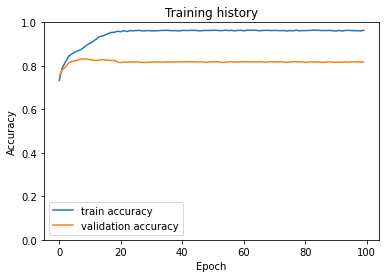

In [11]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/KimVGG/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']

# print(start_epoch)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  scheduler.step(val_acc)
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/KimVGG/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/KimVGG/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}

savepath= "./gdrive/MyDrive/Models/KimVGG/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')


plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [12]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids = input_ids, 
        tweet_img = tweet_imgs
        )
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative'], digits = 4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative     0.7718    0.7549    0.7633       457
    Informative     0.8835    0.8927    0.8881       951

       accuracy                         0.8480      1408
      macro avg     0.8276    0.8238    0.8257      1408
   weighted avg     0.8472    0.8480    0.8476      1408

